# Computing the overall metrics for different pipelines
We Compare the 8x8 bin, bin2cell, enact and xenium segmentation on visium data using simple summary metrics, for example cell count, transcripts per cell, unassigned transcripts and some more.

In this dataset we use the Visium Dataset published by 10X which demonstrated the Visium post Xenium protocol on Lung Cancer Tissue.
It can be found here: link



For this script, I recommend to use the tmp_enact_analysis environment, the yml file can be found in the environments folder. !!!!!

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [2]:

bin_8x8_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_008um/filtered_feature_bc_matrix.h5"
bin_16x16_path = "/srv/gstore/projects/p37785/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_016um/filtered_feature_bc_matrix.h5"
cells_b2c_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cdata.h5ad"
cells_enact_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_xseg_path = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-02--15-53-26/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"


In [3]:
adata_bin_8 = sc.read_h5ad("/srv/gstore/projects/p37785/EzPyzAnndataReportApp_2025-07-23--15-45-57/AnndataReportApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/report/adata_processed.h5ad")
adata_bin_16 = sc.read_10x_h5(bin_16x16_path)
adata_cells_b2c = sc.read_h5ad(cells_b2c_path)
adata_cells_enact = sc.read_h5ad(cells_enact_path)
adata_cells_xseg = sc.read_h5ad(cells_xseg_path)

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
for name, adata in [
    ('bin_8', adata_bin_8),
    ('bin_16', adata_bin_16),
    ('cells_b2c', adata_cells_b2c),
    ('cells_enact', adata_cells_enact),
    ('cells_xseg', adata_cells_xseg)
]:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

In [15]:
# Prepare data for comparison
datasets = {
    '8x8 bin': adata_bin_8,
    '16x16 bin': adata_bin_16,
    'cells b2c': adata_cells_b2c,
    'cells enact': adata_cells_enact,
    'cells xseg': adata_cells_xseg
}
keys = list(datasets.keys())
cell_keys_p8 = ['8x8 bin', 'cells b2c', 'cells enact', 'cells xseg']
cell_keys = ['cells b2c', 'cells enact', 'cells xseg']
cell_colors = ['gray']*2 + ['tab:blue']*len(cell_keys)

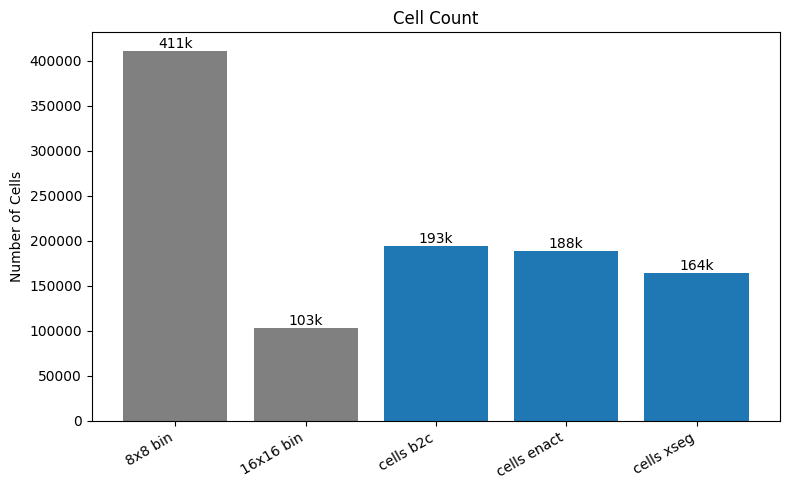

In [6]:
# Plot the number of cells (n_obs) for each dataset
cell_counts = {k: v.n_obs for k, v in datasets.items()}

cell_labels = list(cell_counts.keys())
cell_nums = list(cell_counts.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(cell_labels, cell_nums, color=cell_colors)
plt.ylabel('Number of Cells')
plt.title('Cell Count')
plt.xticks(rotation=30, ha='right')

# Add rounded numbers (in thousands) on top of bars
for bar, num in zip(bars, cell_nums):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{np.floor(num/1000):.0f}k',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

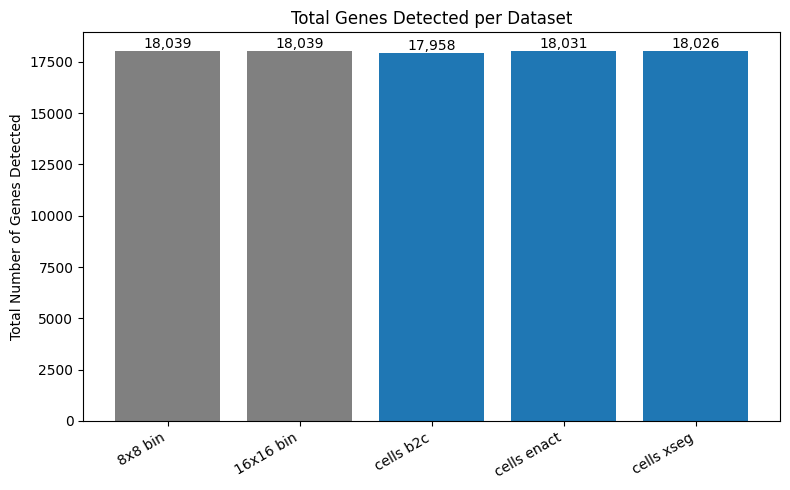

In [7]:
# Calculate total number of genes detected (with at least one count) for each dataset
total_genes_detected = {k: (v.X.sum(axis=0) > 0).sum() for k, v in datasets.items()}

gene_labels = list(total_genes_detected.keys())
gene_nums = list(total_genes_detected.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(gene_labels, gene_nums, color=cell_colors)
plt.ylabel('Total Number of Genes Detected')
plt.title('Total Genes Detected per Dataset')
plt.xticks(rotation=30, ha='right')

# Add actual values above the bars
for bar, num in zip(bars, gene_nums):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{num:,}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

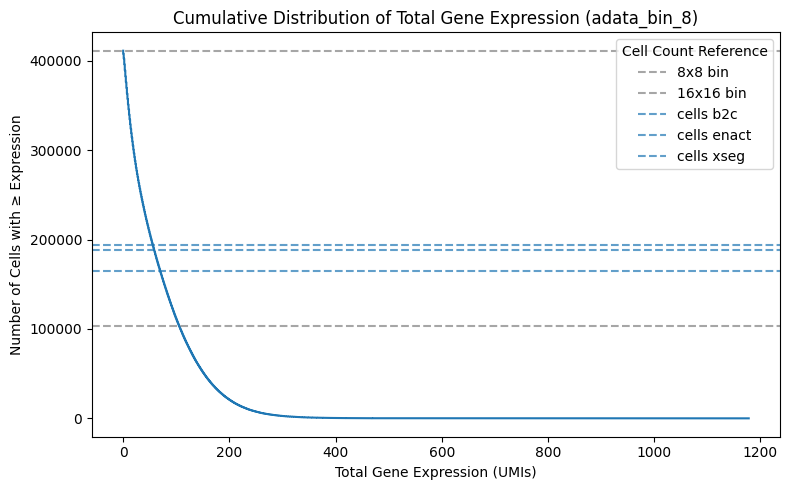

In [8]:
# Plot cumulative distribution of total gene expression for adata_bin_8
total_counts = adata_bin_8.obs['total_counts'].sort_values(ascending=False)
cum_cells = np.arange(1, len(total_counts) + 1)

plt.figure(figsize=(8, 5))
plt.plot(total_counts.values, cum_cells, color='tab:blue')
plt.xlabel('Total Gene Expression (UMIs)')
plt.ylabel('Number of Cells with ≥ Expression')
plt.title('Cumulative Distribution of Total Gene Expression (adata_bin_8)')

# Add horizontal lines at each cell count value, color by label and add legend
for label, count, color in zip(cell_labels, cell_counts.values(), cell_colors):
    plt.axhline(count, color=color, linestyle='--', alpha=0.7, label=label)
plt.legend(title='Cell Count Reference')

plt.tight_layout()
plt.show()

In [9]:
# Find the value of Total Gene Expression (UMIs) where the cumulative curve meets each horizontal cell count line
intersection_values = []
for count in cell_counts.values():
    # Find the index where cum_cells == count (or closest)
    idx = np.searchsorted(cum_cells, count)
    if idx < len(total_counts):
        expr_value = total_counts.values[idx]
    else:
        expr_value = np.nan  # In case count exceeds cum_cells
    intersection_values.append(expr_value)

# Display results
for label, count, expr_value in zip(cell_labels, cell_counts.values(), intersection_values):
    print(f"{label}: Cell count = {count}, Total Gene Expression at intersection = {expr_value:.2f}")

8x8 bin: Cell count = 411242, Total Gene Expression at intersection = 0.00
16x16 bin: Cell count = 103643, Total Gene Expression at intersection = 105.00
cells b2c: Cell count = 193856, Total Gene Expression at intersection = 56.00
cells enact: Cell count = 188596, Total Gene Expression at intersection = 58.00
cells xseg: Cell count = 164273, Total Gene Expression at intersection = 70.00


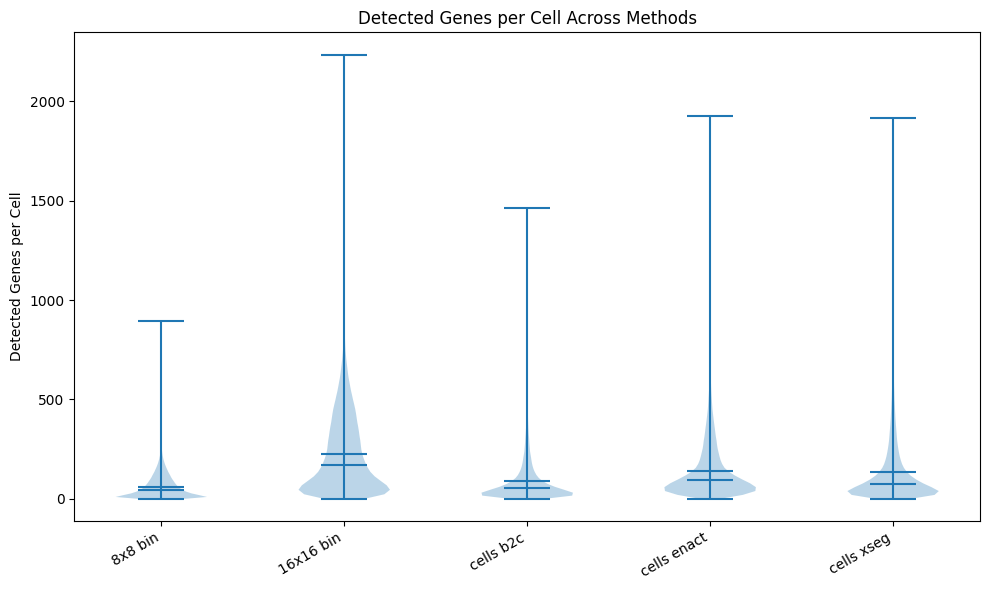

In [10]:
# Prepare data for violin plot: detected genes per cell for each dataset
gene_counts_data = [
    datasets['8x8 bin'].obs['n_genes_by_counts'],
    datasets['16x16 bin'].obs['n_genes_by_counts'],
    datasets['cells b2c'].obs['n_genes_by_counts'],
    datasets['cells enact'].obs['n_genes_by_counts'],
    datasets['cells xseg'].obs['n_genes_by_counts']
]

plt.figure(figsize=(10, 6))
parts = plt.violinplot(gene_counts_data, showmeans=True, showmedians=True, showextrema=True)

plt.xticks(np.arange(1, 6), keys, rotation=30, ha='right')
plt.ylabel('Detected Genes per Cell')
plt.title('Detected Genes per Cell Across Methods')
plt.tight_layout()
plt.show()

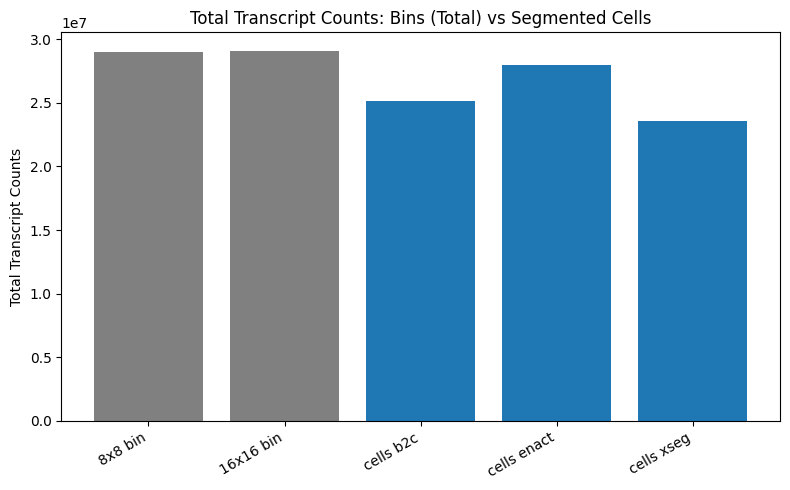

In [11]:
    # Calculate total transcript counts for each dataset
total_counts = {k: v.obs['total_counts'].sum() for k, v in datasets.items()}

# Prepare data for plotting
counts = [total_counts[k] for k in keys]

plt.figure(figsize=(8, 5))
bars = plt.bar(keys, counts, color=cell_colors)
plt.ylabel('Total Transcript Counts')
plt.title('Total Transcript Counts: Bins (Total) vs Segmented Cells')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

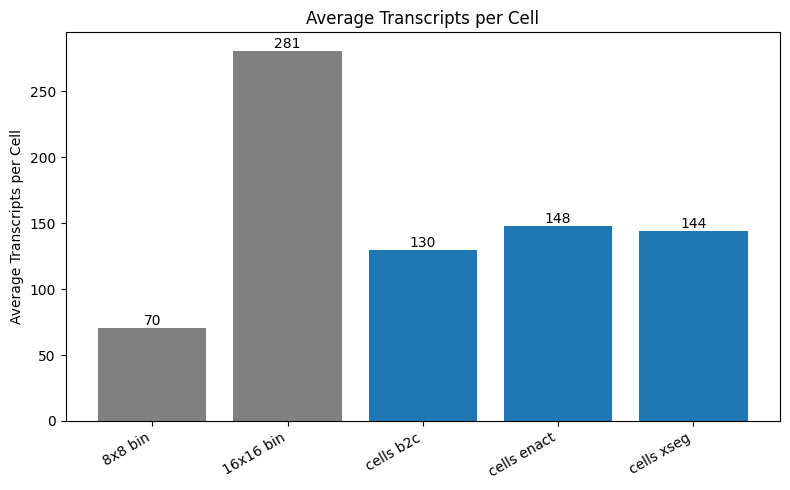

In [12]:
# Calculate average transcripts per cell/nucleus for each dataset
avg_counts = {k: v.obs['total_counts'].mean() for k, v in datasets.items()}


avg_values = [avg_counts[k] for k in keys]

plt.figure(figsize=(8, 5))
bars = plt.bar(keys, avg_values, color=cell_colors, capsize=6)
plt.ylabel('Average Transcripts per Cell')
plt.title('Average Transcripts per Cell')
plt.xticks(rotation=30, ha='right')

# Add actual values above the bars
for bar, val in zip(bars, avg_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{val:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

#decided not to show the std because the disrtibution is obviously not normal and as the variance is quite high, it would just distort the plot

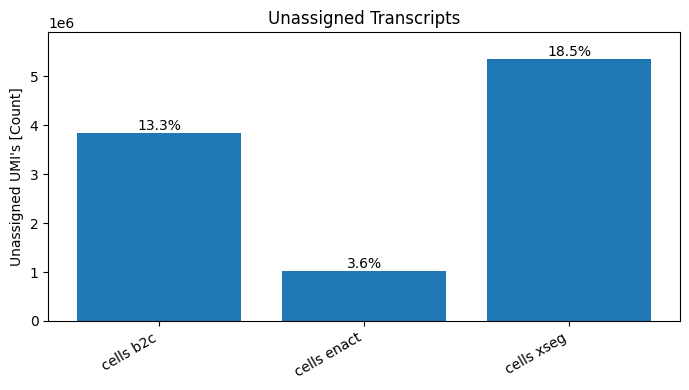

In [13]:
# Calculate unassigned transcripts: difference between bin_8 and each dataset
unassigned_counts = []
unassigned_percents = []
for k in cell_keys:
    diff = total_counts['8x8 bin'] - total_counts[k]
    unassigned_counts.append(diff)
    percent = 100 * diff / total_counts['8x8 bin']
    unassigned_percents.append(percent)

unassigned_labels = cell_keys
unassigned_colors = ['tab:blue']*len(cell_keys)

plt.figure(figsize=(7, 4))
bars = plt.bar(unassigned_labels, unassigned_counts, color=unassigned_colors)
plt.ylabel("Unassigned UMI's [Count]")
plt.title('Unassigned Transcripts')
plt.xticks(rotation=30, ha='right')

# Add space above the highest bar
plt.ylim(top=max(unassigned_counts) * 1.10)

# Overlay percentage labels
for bar, pct in zip(bars, unassigned_percents):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

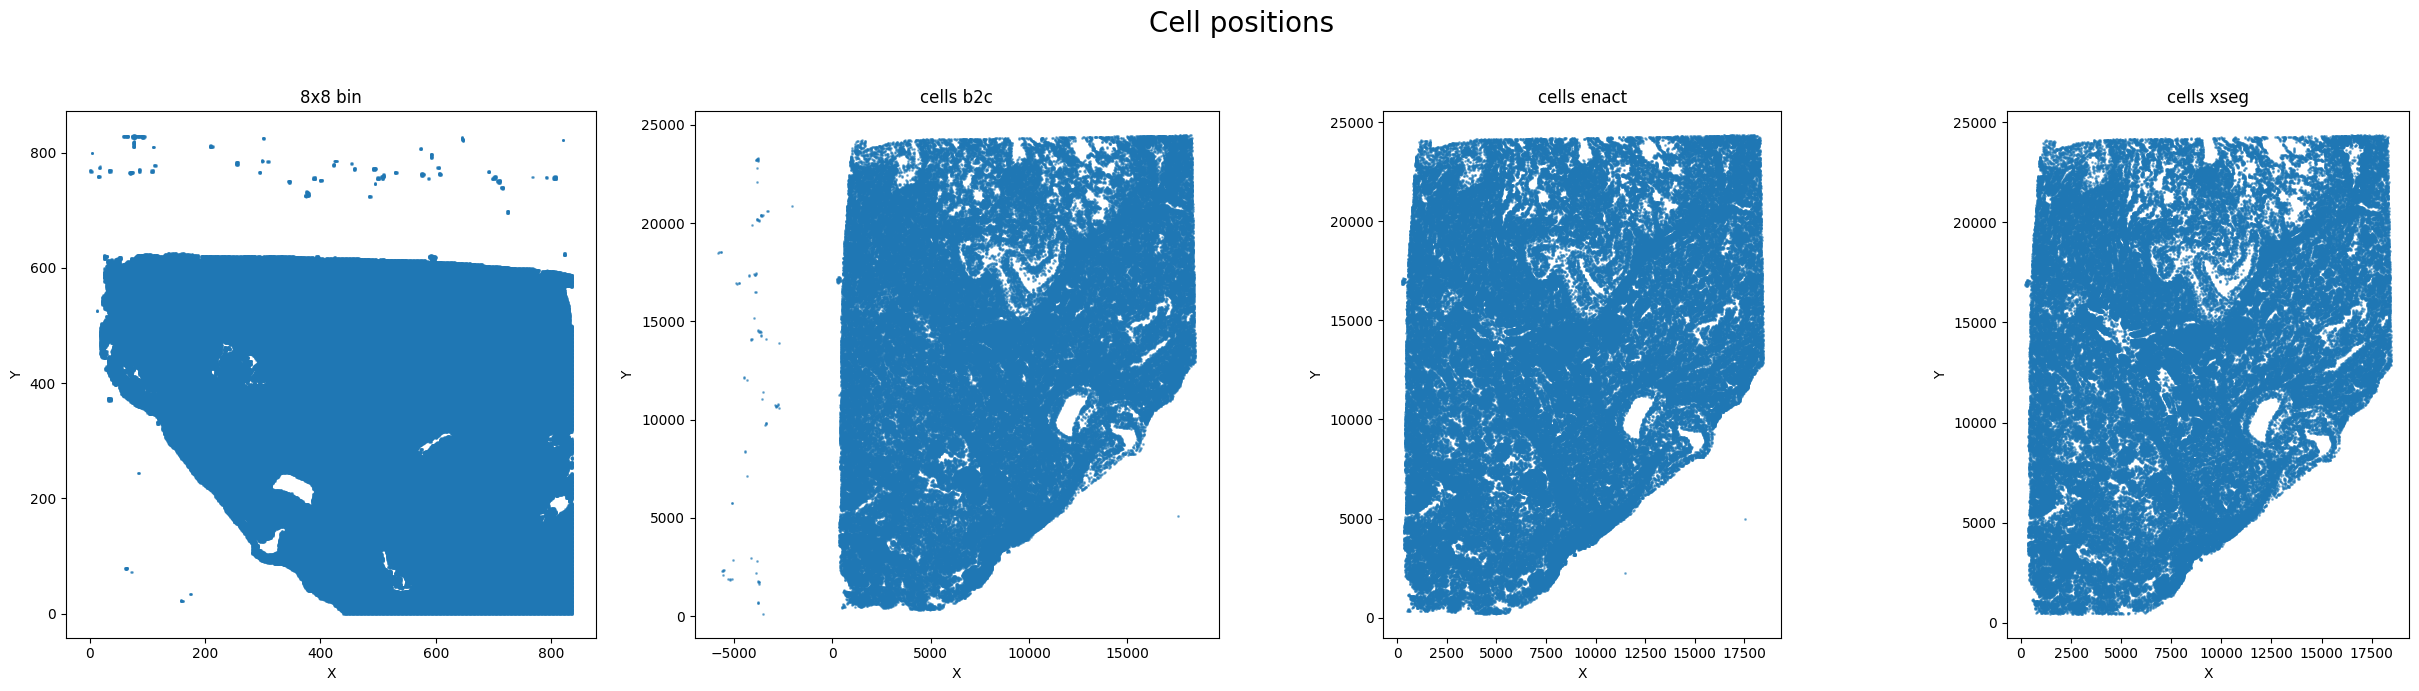

In [16]:
fig, axes = plt.subplots(1, len(cell_keys_p8), figsize=(25, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys_p8):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    try:
        # Try to use as numpy array (works for AnnData with numpy obsm)
        ax.scatter(coords[:,0], coords[:,1], s=1, alpha=0.5)
    except Exception:
        # If coords is a DataFrame, use column names
        try:
            ax.scatter(coords['cell_x'], coords['cell_y'], s=1, alpha=0.5)
        except Exception:
            # Fallback: try generic .iloc
            ax.scatter(coords.iloc[:,0], coords.iloc[:,1], s=1, alpha=0.5)
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
fig.suptitle("Cell positions", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

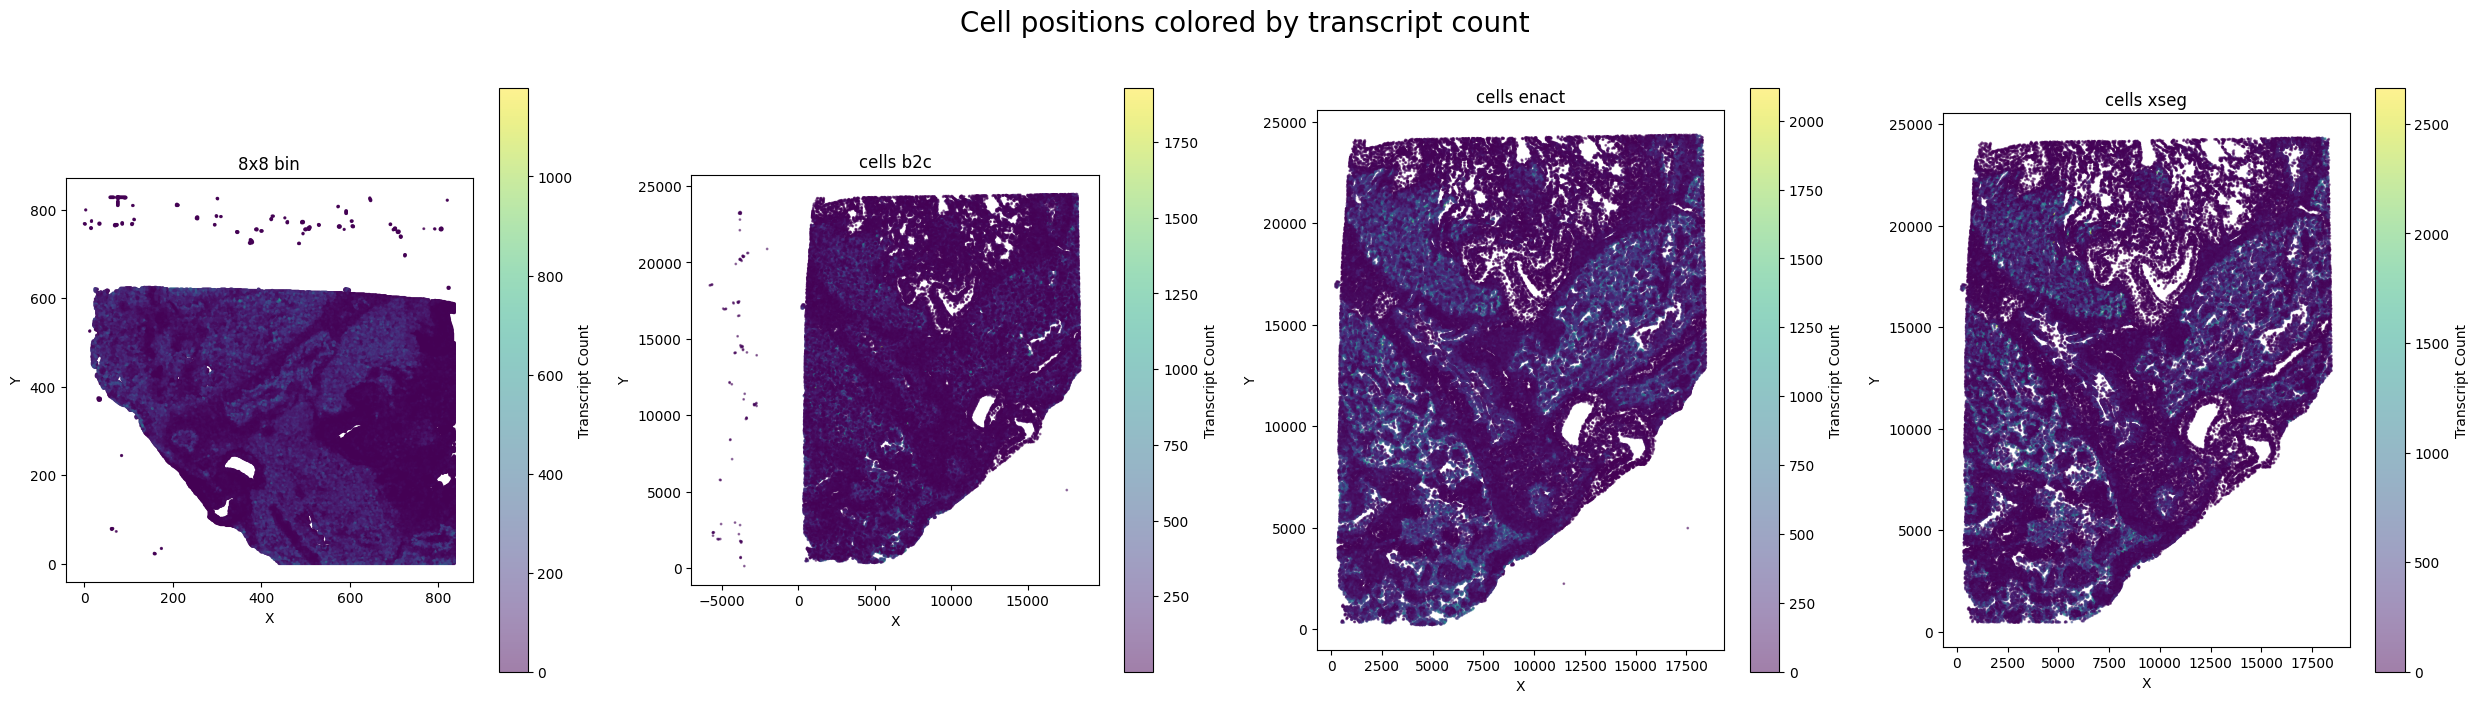

In [21]:
fig, axes = plt.subplots(1, len(cell_keys_p8), figsize=(25, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys_p8):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    counts = adata.obs['total_counts']
    try:
        xy = coords if isinstance(coords, np.ndarray) else coords.values
        x, y = xy[:, 0], xy[:, 1]
    except Exception:
        x, y = coords['cell_x'].values, coords['cell_y'].values

    sc_plot = ax.scatter(x, y, c=counts, s=1, alpha=0.5, cmap='viridis')
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    plt.colorbar(sc_plot, ax=ax, label='Transcript Count')
fig.suptitle("Cell positions colored by transcript count", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plotting cells b2c...
Plotting cells enact...
Plotting cells xseg...


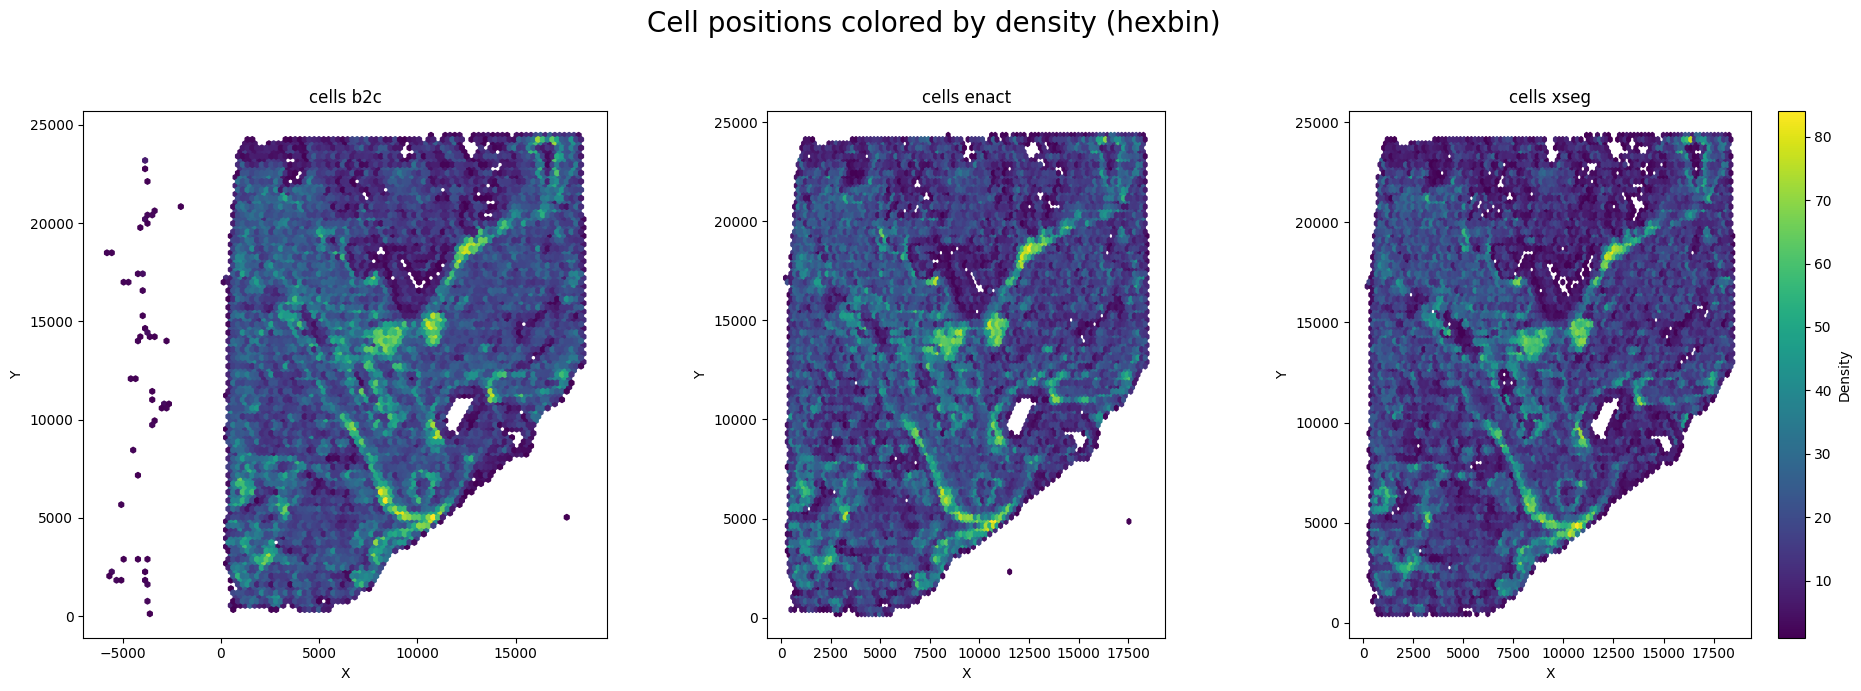

In [18]:
fig, axes = plt.subplots(1, len(cell_keys), figsize=(19, 7), sharex=False, sharey=False)
for ax, key in zip(axes, cell_keys):
    adata = datasets[key]
    coords = adata.obsm['spatial']
    try:
        xy = coords if isinstance(coords, np.ndarray) else coords.values
        x, y = xy[:, 0], xy[:, 1]
    except Exception:
        x, y = coords['cell_x'].values, coords['cell_y'].values

    print(f"Plotting {key}...")
    hb = ax.hexbin(x, y, gridsize=100, cmap='viridis', mincnt=1)
    ax.set_title(key)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    if ax == axes[2]:
        plt.colorbar(hb, ax=ax, label='Density')

fig.suptitle("Cell positions colored by density (hexbin)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


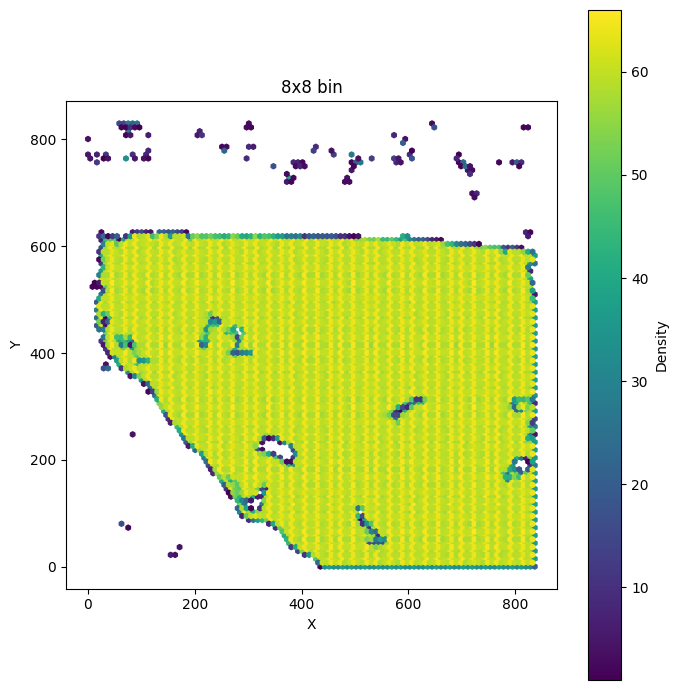

In [ ]:
#for reference..
fig, ax = plt.subplots(figsize=(7, 7))
coords = datasets['8x8 bin'].obsm['spatial']
xy = coords if isinstance(coords, np.ndarray) else coords.values
x, y = xy[:, 0], xy[:, 1]

hb = ax.hexbin(x, y, gridsize=100, cmap='viridis', mincnt=1)
ax.set_title('8x8 bin')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
plt.colorbar(hb, ax=ax, label='Density')

plt.tight_layout()
plt.show()
